#### Import Libraries

In [16]:
# General 
import pandas as pd
import joblib
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Model and Optimization 
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report

#### Load Dataset - Float

In [2]:
# Load float data
data_floats = pd.read_csv('../data/labelled/all_floats.csv')

In [3]:
# get a fraction of the dataset for optimization purposes
def stratified_sampling(dataset: pd.DataFrame, column_name: str, sample_size: int):
    # Load the dataset into a pandas DataFrame
    df = dataset

    # Perform stratified sampling
    stratified_sample = df.groupby(column_name, group_keys=False).apply(lambda x: x.sample(int(sample_size/len(df)*len(x))))

    # Reset the index of the stratified sample DataFrame
    stratified_sample.reset_index(drop=True, inplace=True)

    return stratified_sample

In [4]:
# Undersample any target label with count > mean count of the dataset

def undersample_by_value_counts(data, label_column):
    value_counts = data[label_column].value_counts()
    mean_count = value_counts.mean()

    undersampled_data = pd.DataFrame(columns=data.columns)

    for value, count in value_counts.items():
        if count > mean_count:
            undersampled_count = int((count / value_counts.sum()) * mean_count)
            subset = data[data[label_column] == value].sample(n=undersampled_count, random_state=42)
            undersampled_data = pd.concat([undersampled_data, subset], ignore_index=True)
        else:
            subset = data[data[label_column] == value]
            undersampled_data = pd.concat([undersampled_data, subset], ignore_index=True)

    # Randomize the undersampled data
    randomized_data = undersampled_data.sample(frac=1, random_state=42)

    return randomized_data

In [17]:
sample_data = stratified_sampling(data_floats, 'label', 100000)

In [18]:
sample_data['label'].value_counts()

label
0.0     59682
6.0     32967
2.0      2626
1.0      2026
7.0      1491
9.0       629
5.0       363
8.0        85
10.0       62
4.0        49
3.0        16
Name: count, dtype: int64

Undersample imbalanced labels

In [7]:
undersampled_data = undersample_by_value_counts(sample_data, 'label')

In [8]:
undersampled_data['label'].value_counts()

label
0.0     5425
6.0     2996
2.0     2626
1.0     2026
7.0     1491
9.0      629
5.0      363
8.0       85
10.0      62
4.0       49
3.0       16
Name: count, dtype: int64

In [19]:
# Get required columns
new_features = selected_features_no_encoder.copy()
new_features.append('label')
undersampled_data_optimized  = undersampled_data[new_features]

In [20]:
# undersampled_data['label'].value_counts().sum()
undersampled_data_optimized.shape

(15768, 41)

Encode data

In [10]:
# encoder = joblib.load('cat_feat_encoder.pkl')
# encoder_cols = joblib.load('encoder_columns.pkl')

# encoded_data = encoder.transform(undersampled_data[encoder_cols])

# # Create a DataFrame from the encoded data
# encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(encoder_cols))

# # Remove the original columns from the dataset
# undersampled_data.drop(encoder_cols, axis=1, inplace=True)

# # Concatenate the encoded DataFrame with the remaining columns of the dataset
# data_encoded = pd.concat([undersampled_data, encoded_df], axis=1)

#### Train-Test Split

In [21]:
# select data to split
data_used = undersampled_data_optimized

X = data_used.drop('label', axis=1) # Inputs
y = data_used['label'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y,
                                                    shuffle=True)

#### Scale the inputs

In [22]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
X_train_scaled.shape

(12614, 40)

In [15]:
# Experiment with saving and loading files back

# Save data
path=''
np.savetxt(str(path+'X_train_scaled.csv'), X_train_scaled, delimiter=',')
np.savetxt(str(path+'X_test_scaled.csv'), X_test_scaled, delimiter=',')
y_train.to_csv(str(path+'y_train.csv'), index=False, header=False, mode='w')
y_test.to_csv(str(path+'y_test.csv'), index=False, header=False, mode='w')

# Load data
X_train_scaled = np.genfromtxt('X_train_scaled.csv', delimiter=',')
X_test_scaled = np.genfromtxt('X_test_scaled.csv', delimiter=',')
y_train = np.genfromtxt('y_train.csv', delimiter=',')
y_test = np.genfromtxt('y_test.csv', delimiter=',')

#### Feature Selection - Recursive Feature Elimination

Setup Baseline Model - Gradient Boosting Classifier

In [34]:
# Classification Report for each type of attack
def print_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)

    for class_label, metric in report.items():
        try:
            f1_score_float = metric['f1-score']
            print(f"Class {class_label}: F1-score = {round(f1_score_float, 3)}")
        except:
            pass

In [35]:
# Initialize classifier
gbc = GradientBoostingClassifier(random_state=42)

# Train classifier using all features
gbc.fit(X_train_scaled, y_train)

# Make predictions
preds = gbc.predict(X_test_scaled)

# Evaluate model (F1 Score)
print_f1_scores(y_test, preds)

Class 0.0: F1-score = 0.997
Class 1.0: F1-score = 0.999
Class 2.0: F1-score = 1.0
Class 3.0: F1-score = 1.0
Class 4.0: F1-score = 1.0
Class 5.0: F1-score = 1.0
Class 6.0: F1-score = 1.0
Class 7.0: F1-score = 1.0
Class 8.0: F1-score = 1.0
Class 9.0: F1-score = 0.992
Class 10.0: F1-score = 0.897
Class macro avg: F1-score = 0.99
Class weighted avg: F1-score = 0.998


Setup RFE Feature Selector

In [156]:
f1_score_list_weighted = []
f1_score_list_macro = []

for k in range(35,55,5):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=40)
    RFE_selector.fit(X_train_scaled, y_train)

    sel_X_train = RFE_selector.transform(X_train_scaled)
    sel_X_test = RFE_selector.transform(X_test_scaled)

    gbc.fit(sel_X_train, y_train)
    RFE_preds = gbc.predict(sel_X_test)

    f1_score_rfe_weighted = round(f1_score(y_test, RFE_preds, average='weighted'), 3)
    f1_score_rfe_macro = round(f1_score(y_test, RFE_preds, average='macro'), 3)
    f1_score_list_weighted.append(f1_score_rfe_weighted)
    f1_score_list_macro.append(f1_score_rfe_macro)

    print(f"Class scores for {k} features model:")
    print_f1_scores(y_test, RFE_preds)
    print('##----------------------------------------##\n')


    

Class scores for 35 features model:
Class 0.0: F1-score = 0.997
Class 1.0: F1-score = 1.0
Class 2.0: F1-score = 1.0
Class 3.0: F1-score = 0.8
Class 4.0: F1-score = 0.909
Class 5.0: F1-score = 1.0
Class 6.0: F1-score = 1.0
Class 7.0: F1-score = 1.0
Class 8.0: F1-score = 0.97
Class 9.0: F1-score = 0.992
Class 10.0: F1-score = 0.846
Class macro avg: F1-score = 0.956
Class weighted avg: F1-score = 0.997
##----------------------------------------##

Class scores for 40 features model:
Class 0.0: F1-score = 0.998
Class 1.0: F1-score = 1.0
Class 2.0: F1-score = 1.0
Class 3.0: F1-score = 0.8
Class 4.0: F1-score = 0.909
Class 5.0: F1-score = 1.0
Class 6.0: F1-score = 1.0
Class 7.0: F1-score = 1.0
Class 8.0: F1-score = 0.97
Class 9.0: F1-score = 0.992
Class 10.0: F1-score = 0.88
Class macro avg: F1-score = 0.959
Class weighted avg: F1-score = 0.998
##----------------------------------------##



KeyboardInterrupt: 

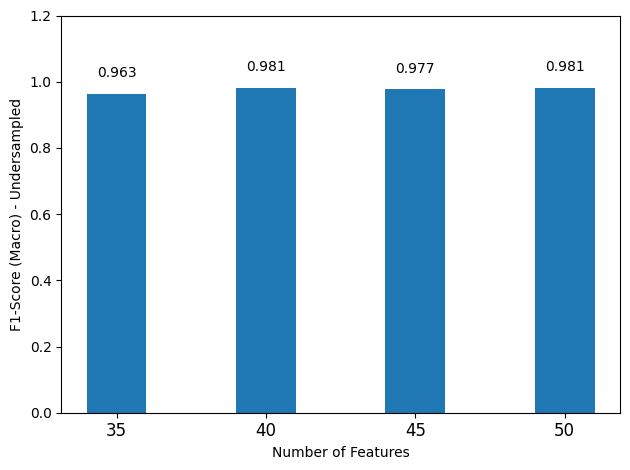

In [123]:
# Plot the outcome
fig, ax = plt.subplots()

x = np.arange(35,55,5)
y = f1_score_list_macro


ax.bar(x, y, width=2)
ax.set_xlabel('Number of Features')
ax.set_ylabel('F1-Score (Macro) - Undersampled')
ax.set_ylim(0, 1.2)
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=12)

for i, v in enumerate(y):
    ax.text(x=x[i], y=v + 0.05, s=str(v), ha='center')

plt.tight_layout()
plt.show()

In [127]:
# Get the list of features used to get best performance
RFE_selector = RFE(estimator=gbc, n_features_to_select=40, step=40)
RFE_selector.fit(X_train_scaled, y_train)

selected_features_mask = RFE_selector.get_support()



In [136]:
selected_features = []

for i,j in zip(X_train.columns, selected_features_mask):
    if j == True:
        selected_features.append(i)

In [16]:
selected_features_no_encoder = [
    'timestamp', 'ip_len', 'ip_id', 'ip_flags', 'ip_ttl', 'ip_proto',
    'ip_checksum', 'ip_dst', 'ip_dst_host','tcp_srcport', 'tcp_dstport',
    'tcp_port', 'tcp_stream', 'tcp_completeness', 'tcp_seq_raw', 'tcp_ack',
    'tcp_ack_raw', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_window_size_value',
    'tcp_window_size', 'tcp_window_size_scalefactor', 'tcp_', 'udp_srcport',
    'udp_dstport', 'udp_port', 'udp_length', 'udp_time_delta', 'eth_dst_oui',
    'eth_addr_oui', 'eth_dst_lg', 'eth_lg', 'eth_ig', 'eth_src_oui', 'eth_type',
    'icmp_type', 'icmp_code', 'icmp_checksum', 'icmp_checksum_status', 'arp_opcode'
    ]